In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from arch.unitroot import DFGLS
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from scipy import signal

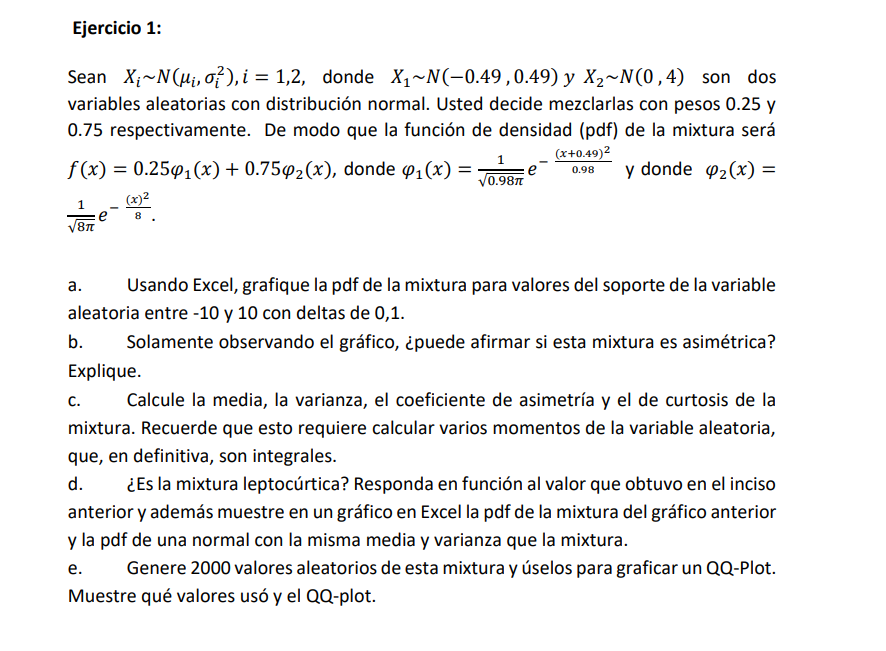

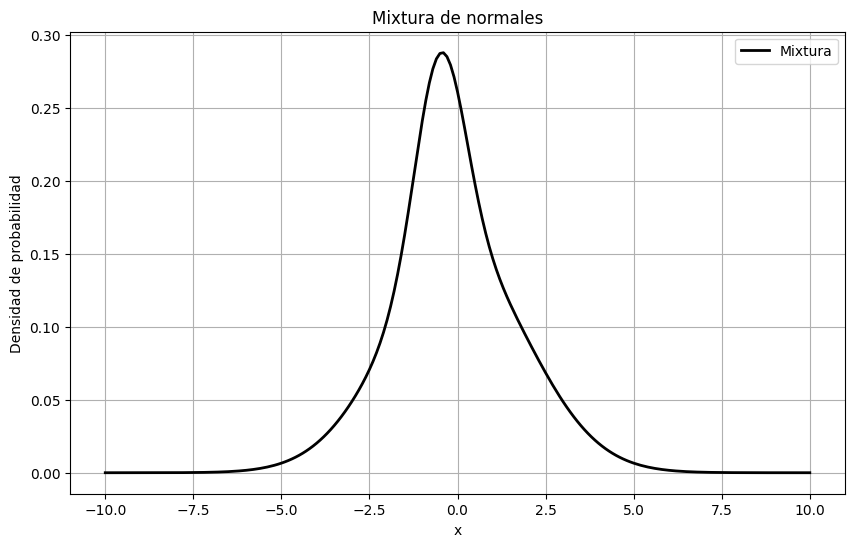

In [2]:
valores = np.arange(-10, 10.1, 0.1)
df = pd.DataFrame({'values': valores})

w1 = 0.25
mu1 = -0.49
var1 = 0.49

w2 = 0.75
mu2 = 0
var2 = 4

# Genero las pdfs
df['pdf_1'] = stats.norm.pdf(df['values'], loc=mu1, scale=np.sqrt(var1))
df['pdf_2'] = stats.norm.pdf(df['values'], loc=mu2, scale=np.sqrt(var2))
df['pdf_mixture'] = w1 * df['pdf_1'] + w2 * df['pdf_2']

plt.figure(figsize=(10, 6))
plt.plot(df['values'], df['pdf_mixture'], label="Mixtura", color="black", linewidth=2)
plt.title("Mixtura de normales")
plt.xlabel("x")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.grid(True)
plt.show()

Se puede observar que es asimetrica, lo cual es esperable ya que la media de las dos normales no es la misma

In [ ]:
# Media de la mixtura
mu_mix = w1 * mu1 + w2 * mu2

# Varianza de la mixtura
var_mix = w1 * (var1 + (mu1 - mu_mix) ** 2) + w2 * (var2 + (mu2 - mu_mix) ** 2)
std_mix = np.sqrt(var_mix)

# Tercer momento centrado
mu_3 = (
    w1 * ((mu1 - mu_mix) ** 3 + 3 * (mu1 - mu_mix) * var1)
    + w2 * ((mu2 - mu_mix) ** 3 + 3 * (mu2 - mu_mix) * var2))

# Cuarto momento centrado
mu_4 = (
    w1 * ((mu1 - mu_mix) ** 4 + 6 * (mu1 - mu_mix) ** 2 * var1 + 3 * var1 ** 2)
    + w2 * ((mu2 - mu_mix) ** 4 + 6 * (mu2 - mu_mix) ** 2 * var2 + 3 * var2 ** 2))

# Asimetría y kurtosis
skewness = mu_3 / (std_mix ** 3)
kurtosis_total = mu_4 / (var_mix ** 2)
kurtosis_exceso = kurtosis_total - 3

print("Media:", mu_mix)
print("Varianza:", round(var_mix,5))
print("Desvi std:", round(std_mix,5))
print("Tercer momento μ₃:", round(mu_3,5))
print("Cuarto momento μ₄:",   round(mu_4,5))
print("Asimetría:", round(skewness,5))
print("Kurtosis:", round(kurtosis_total,5))
print("Kurtosis en Exceso:", round(kurtosis_exceso,5))

Media: -0.1225
Varianza: 3.16752
Desvi std: 1.77975
Tercer momento μ₃: 0.95641
Cuarto momento μ₄: 36.55418
Asimetría: 0.16966
Kurtosis: 3.64333
Kurtosis en Exceso: 0.64333


Dado que la Kurtosis en Exceso es > 0, la distribucion es Leptocurtica

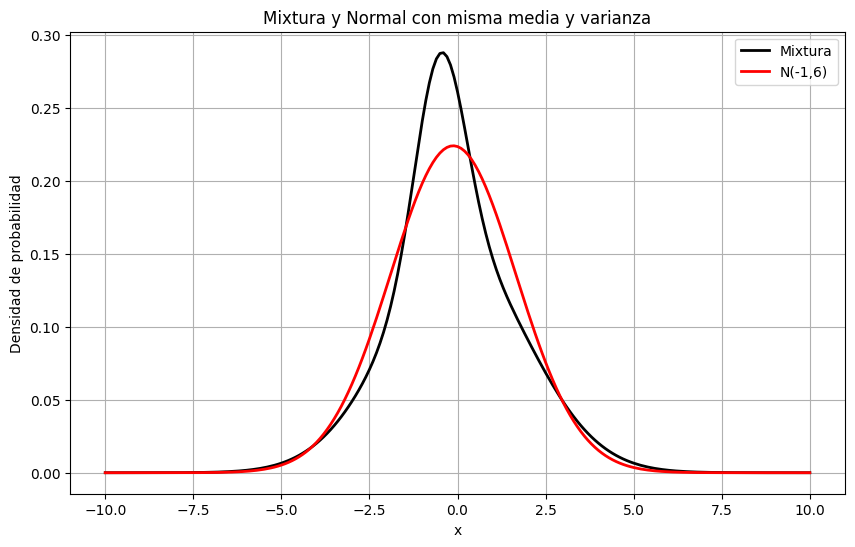

In [9]:
df['pdf_3'] = stats.norm.pdf(df['values'], loc=-0.1225, scale=1.77975)

plt.figure(figsize=(10, 6))
plt.plot(df['values'], df['pdf_mixture'], label="Mixtura", color="black", linewidth=2)
plt.plot(df['values'], df['pdf_3'], label="N(-1,6)", color="red", linewidth=2)
plt.title("Mixtura y Normal con misma media y varianza")
plt.xlabel("x")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.grid(True)
plt.show()

Media: -0.11468988249254605
Desviación estándar: 1.7684591842855863


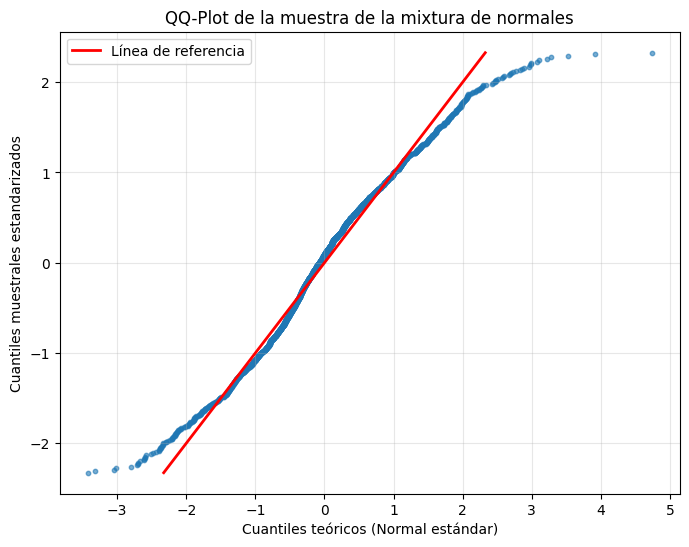

[-0.34842333 -0.14950135  3.07700914 ... -0.24083948 -1.02743282
 -0.41222901]


In [11]:
# QQ Plot usando matplotlib
n = 2000
weights = [w1, w2]
mus = [mu1, mu2]
sigmas = [0.7, 2]

sample = np.zeros(n)
for i in range(n):
    component = np.random.choice([0, 1], p=weights)
    sample[i] = np.random.normal(mus[component], sigmas[component])

print(f"Media: {np.mean(sample)}")
print(f"Desviación estándar: {np.std(sample)}")

# Estandarizar la muestra
sample_standardized = (sample - np.mean(sample)) / np.std(sample)

# Ordenar la muestra
sample_sorted = np.sort(sample_standardized)

# Calcular los cuantiles teóricos de la distribución normal estándar
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sample_sorted)))

# Crear el QQ-plot
plt.figure(figsize=(8, 6))
plt.scatter(sample_sorted, theoretical_quantiles, alpha=0.6, s=10)

# Agregar línea de referencia (línea diagonal perfecta)
plt.plot([theoretical_quantiles.min(), theoretical_quantiles.max()], 
         [theoretical_quantiles.min(), theoretical_quantiles.max()], 
         'r-', linewidth=2, label='Línea de referencia')

plt.xlabel("Cuantiles teóricos (Normal estándar)")
plt.ylabel("Cuantiles muestrales estandarizados")
plt.title("QQ-Plot de la muestra de la mixtura de normales")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(sample_standardized)

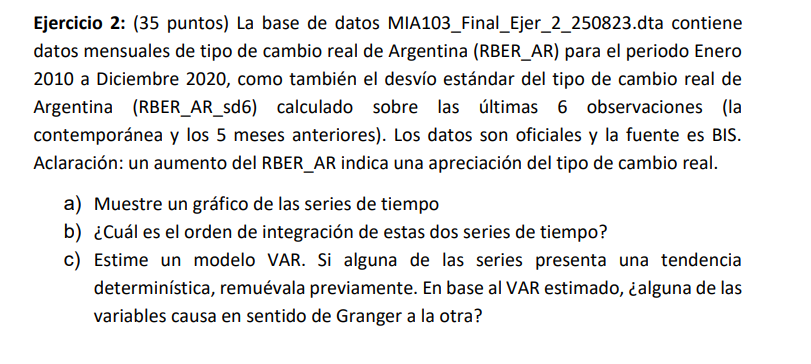

In [61]:
df = pd.read_stata("MIA103_Final_Ejer_2_250823.dta")
df.head()

,RBER_AR,RBER_AR_sd6,t
0,98.870003,1.225477,2010-01-01
1,100.620003,1.976474,2010-02-01
2,99.820000,2.138749,2010-03-01
3,99.349998,1.786254,2010-04-01
4,102.059998,1.618118,2010-05-01


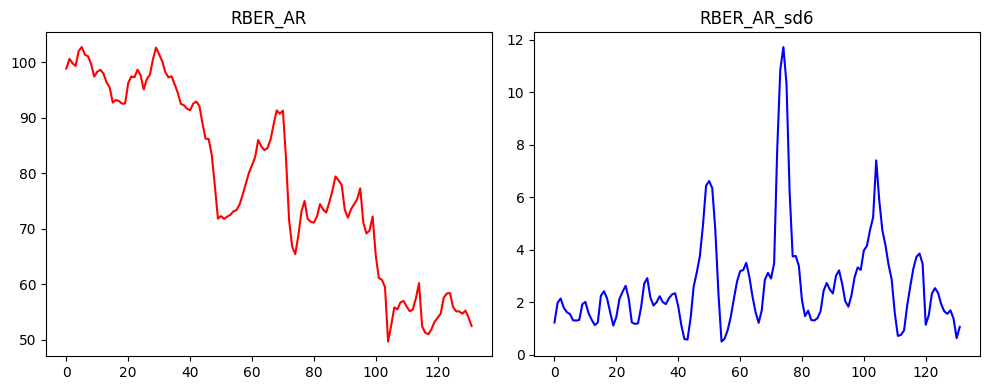

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(df["RBER_AR"], color='red')
axes[0].set_title("RBER_AR")

axes[1].plot(df["RBER_AR_sd6"], color='blue')
axes[1].set_title("RBER_AR_sd6")

plt.tight_layout()
plt.show()

Del grafico, podemos observar que RBER_AR parece ser NO Estacionaria; mientras que RBER_AR_sd6 si

In [63]:
# Corro ADF para RBER_AR en I(0)
test = DFGLS(df["RBER_AR"].dropna(), trend="c")
print("RBER_AR")
print(test.summary())
# Nos da que es No Estacionaria, p-value > 0.05 con lo cual no rechazamos la hipotesis nula que la serie tiene una raiz unitaria por lo cual la serie es no estacionaria

# Corro tambien con ct
test = DFGLS(df["RBER_AR"].dropna(), trend="ct")
print("\nRBER_AR con ct")
print(test.summary())

# Se observa que la serie es I(0) con tendencia deterministica

# Calculo con primeras diferencias I(1)
#df['dRBER_AR'] = df['RBER_AR'].diff()

#test = DFGLS(df["dRBER_AR"].dropna(), trend="c")
#print("\nDiff RBER_AR")
#print(test.summary())
# Se puede observar que en primeras diferencias es Estacionaria



RBER_AR
      Dickey-Fuller GLS Results      
Test Statistic                  0.108
P-value                         0.729
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -2.72 (1%), -2.10 (5%), -1.78 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

RBER_AR con ct
      Dickey-Fuller GLS Results      
Test Statistic                 -3.470
P-value                         0.009
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.57 (1%), -2.99 (5%), -2.70 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [71]:
# Regresiom
k_lags = 1
y = df["RBER_AR"].dropna()
T = len(y)
t = np.arange(1, T+1) # tendencia lineal
dy = y.diff()

X = pd.DataFrame({
    "const": 1.0,
    "trend": t,
    "y_lag1": y.shift(1),
})

# agrega Δy_{t-i}, i=1..k
for i in range(1, k_lags+1):
    X[f"dy_lag{i}"] = dy.shift(i)

# variable dependiente: Δy_t
Y = dy

# 3) alineá y ajustá OLS
data = pd.concat([Y, X], axis=1).dropna()
Y_ols = data.iloc[:, 0]
X_ols = data.iloc[:, 1:]

res = sm.OLS(Y_ols, X_ols).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                RBER_AR   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     10.19
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           4.69e-06
Time:                        19:44:11   Log-Likelihood:                -293.33
No. Observations:                 130   AIC:                             594.7
Df Residuals:                     126   BIC:                             606.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7003      3.778      3.627      0.0

In [64]:
# Corro ADF para RBER_AR_sd6 en I(0)
test = DFGLS(df["RBER_AR_sd6"].dropna(), trend="c")
print("RBER_AR_sd6")
print(test.summary())

# Se puede observar que es de orden 0

RBER_AR_sd6
      Dickey-Fuller GLS Results      
Test Statistic                 -3.505
P-value                         0.001
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -2.72 (1%), -2.10 (5%), -1.78 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [ ]:
# Como RBER_AR tiene una TD hay que eliminarla
df["RBER_AR_detrend"] = np.nan
serie = df['RBER_AR'].dropna()

df.loc[serie.index,"RBER_AR_detrend"] = signal.detrend(serie.values, type='linear')
df.head()

,RBER_AR,RBER_AR_sd6,t,RBER_AR_detrend
0,98.870003,1.225477,2010-01-01,-5.701355
1,100.620003,1.976474,2010-02-01,-3.553543
2,99.820000,2.138749,2010-03-01,-3.955734
3,99.349998,1.786254,2010-04-01,-4.027924
4,102.059998,1.618118,2010-05-01,-0.920113


In [66]:
# Corro el modelo VAR sin la TD
df_var = df[['RBER_AR_detrend', 'RBER_AR_sd6']].dropna()

# Corro un VAR
model = VAR(df_var)
sel = model.select_order(maxlags=24,trend="c")
print("\n=== Selección de rezagos ===")
print(sel.summary())

# Fitteo con el número de rezagos seleccionados por BIC, en este caso 2
results = model.fit(sel.bic) # trend='ct') # c = const, t = trend
print("\n=== Resumen VAR ===")
print(results.summary())

# Bajo el criterio de BIC, podemos observar que el mejor modelo se obtiene con 2 rezagos, es decir que el valor actual depende del valor de 2 meses atras


=== Selección de rezagos ===
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.906       4.956       135.1       4.926
1        1.717       1.866       5.566       1.777
2       1.081*      1.329*      2.948*      1.182*
3        1.096       1.444       2.994       1.237
4        1.142       1.589       3.135       1.323
5        1.207       1.753       3.348       1.429
6        1.203       1.849       3.338       1.465
7        1.165       1.910       3.218       1.467
8        1.204       2.049       3.352       1.547
9        1.184       2.127       3.291       1.566
10       1.216       2.259       3.407       1.639
11       1.245       2.388       3.521       1.709
12       1.144       2.386       3.194       1.648
13       1.193       2.534       3.368       1.737
14       1.252       2.693       3.595       1.836
15       1.323       2.863       3.882       1.948
1

De los p-values obtenidos uno podria decir que para RBER_AR_sd6, el segundo rezago de la diferencia L2.dREBER_AR no es estadisticamente significativo, su p-value es > 0.10

In [67]:
# Reviso la estabilidad del modelo

roots = results.roots
print("Raíces del VAR(2):")
print(np.abs(roots))  # quiero que sean mayores a 1

Raíces del VAR(2):
[1.64078722 1.64078722 1.35084352 1.35084352]


In [68]:
# Correo el test de Causalidad Granger

#print(results.test_causality("dRBER_AR", ["RBER_AR_sd6"], kind="f"))
#print(results.test_causality("RBER_AR_sd6", ["dRBER_AR"], kind="f"))

print("\n=== Test de Causalidad de Granger ===")
varnames = df_var.columns
for caused in varnames:
    causing = [v for v in varnames if v != caused]
    test = results.test_causality(caused=caused, causing=causing, kind="f")
    print(f"Hipótesis: {causing} → {caused}")
    print(test.summary())
    print()

# Se observa que RBER_AR (sin td) causa en sentido de Granger a RBER_AR_sd6, ya que estoy rechanzando H0
# No asi, el caso contrario, no hay evidencia que RBER_AR_sd6 cause en sentido de Granger a RBER_AR


=== Test de Causalidad de Granger ===
Hipótesis: ['RBER_AR_sd6'] → RBER_AR_detrend
Granger causality F-test. H_0: RBER_AR_sd6 does not Granger-cause RBER_AR_detrend. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.1308          3.032   0.877 (2, 250)
----------------------------------------------

Hipótesis: ['RBER_AR_detrend'] → RBER_AR_sd6
Granger causality F-test. H_0: RBER_AR_detrend does not Granger-cause RBER_AR_sd6. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         5.094          3.032   0.007 (2, 250)
----------------------------------------------



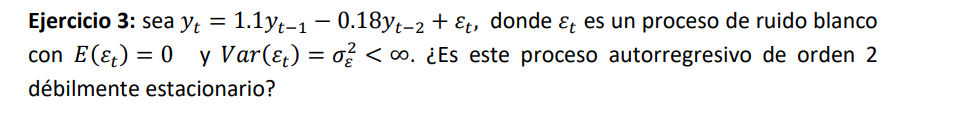

Un AR(1) es débilmente estacionario si |𝜌| < 1, o sea, la raíz de 1 − 𝜌𝑧 = 0 sea mayor a uno.

Un proceso AR(2) es débilmente estacionario si las raíces de 1 − 𝜌1𝑧 − 𝜌2𝑧^2 = 0 estan fuera del cirulo unitario.

In [ ]:
# Este proceso puede reescribirse como yt(1 - 1.1L + 0.18L2) = et

cte = 1
rho1 = 1.1
rho2 = -0.18

coeffs = [cte, -rho1, -rho2]
roots = np.roots(coeffs)

print("Raíces del polinomio:", roots)
print("Módulos de las raíces:", np.abs(roots))

# En este caso el proceso no es debilmente estacionario ya que sus raices (modulo) son todas menores a 1

Raíces del polinomio: [0.9 0.2]
Módulos de las raíces: [0.9 0.2]


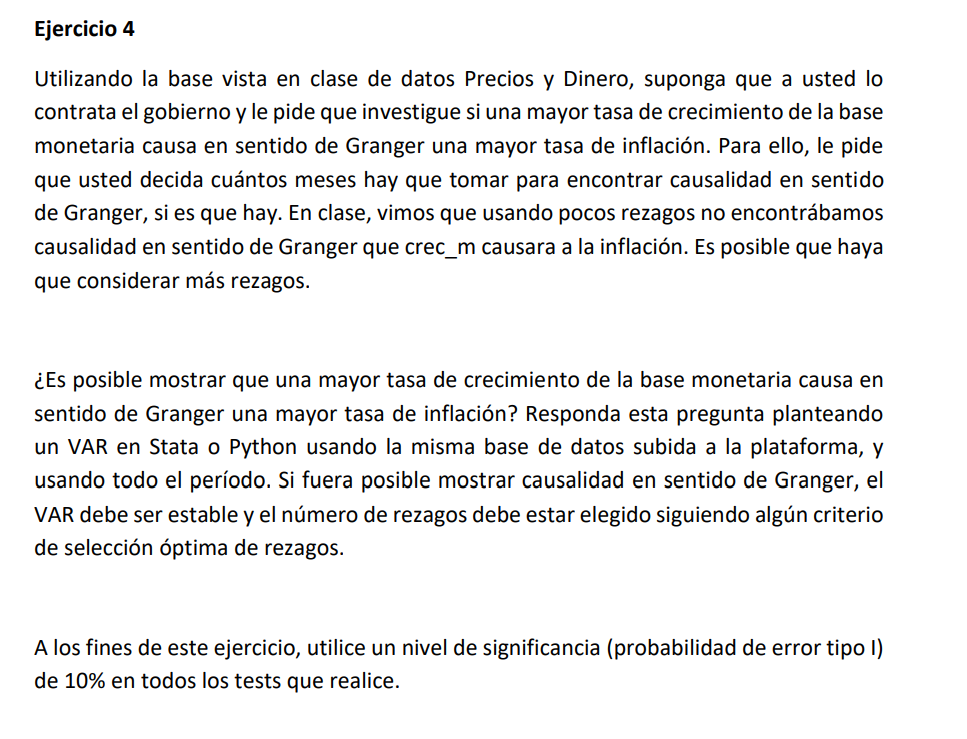

In [73]:
df = pd.read_excel('Precios_y_Dinero.xlsx', sheet_name='Hoja1', usecols='A:D')

# Genero las columnas de inflacion y crec_m
df["inflacion"] = df["IPC"] / df["IPC"].shift(1) - 1
df["crec_m"] = df["M"] / df["M"].shift(1) - 1

df.head()

,MMYY,IPC,M,M_en_ARS,inflacion,crec_m
0,2003-01-01,100.000000,100.000000,29609.920333,NaN,NaN
1,2003-02-01,100.566796,99.359830,29420.366429,0.005668,-0.006402
2,2003-03-01,101.155116,102.628052,30388.084290,0.005850,0.032893
3,2003-04-01,101.212513,104.258927,30870.985333,0.000567,0.015891
4,2003-05-01,100.817908,111.804321,33105.170323,-0.003899,0.072372


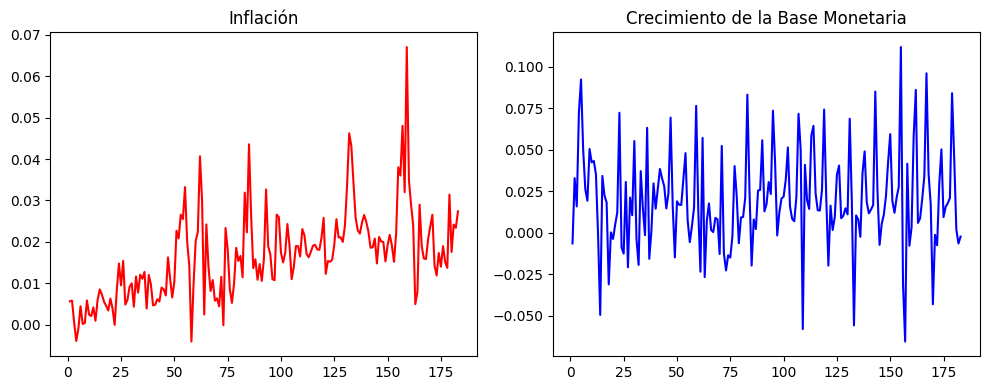

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(df["inflacion"], color='red')
axes[0].set_title("Inflación")
axes[1].plot(df["crec_m"], color='blue')
axes[1].set_title("Crecimiento de la Base Monetaria")

plt.tight_layout()
plt.show()

In [77]:
adf = adfuller(df["inflacion"].dropna(), regression="c", autolag="AIC")

print("Estadístico ADF:", adf[0])
print("p-valor:", adf[1])
print("Número de rezagos usados:", adf[2])
print("Número de observaciones usadas:", adf[3])
print("Valores críticos:", adf[4],"\n")

adf = adfuller(df["inflacion"].dropna(), regression="ct", autolag="AIC")

print("Estadístico ADF:", adf[0])
print("p-valor:", adf[1])
print("Número de rezagos usados:", adf[2])
print("Número de observaciones usadas:", adf[3])
print("Valores críticos:", adf[4],"\n")

Estadístico ADF: -4.457970592047384
p-valor: 0.00023403966364150578
Número de rezagos usados: 1
Número de observaciones usadas: 181
Valores críticos: {'1%': -3.467004502498507, '5%': -2.8776444997243558, '10%': -2.575355189707274} 

Estadístico ADF: -7.720398146539164
p-valor: 3.1636716608129587e-10
Número de rezagos usados: 0
Número de observaciones usadas: 182
Valores críticos: {'1%': -4.009392790586421, '5%': -3.434893396561173, '10%': -3.141378799874199} 



In [ ]:
# corro la regresion para saber si la TD es significativa

k_lags = 0
y = df["inflacion"].dropna()
T = len(y)
t = np.arange(1, T+1) # tendencia lineal
dy = y.diff()

X = pd.DataFrame({
    "const": 1.0,
    "trend": t,
    "y_lag1": y.shift(1),
})

# agrega Δy_{t-i}, i=1..k
for i in range(1, k_lags+1):
    X[f"dy_lag{i}"] = dy.shift(i)

# variable dependiente: Δy_t
Y = dy

# 3) alineá y ajustá OLS
data = pd.concat([Y, X], axis=1).dropna()
Y_ols = data.iloc[:, 0]
X_ols = data.iloc[:, 1:]

res = sm.OLS(Y_ols, X_ols).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              inflacion   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     29.80
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           6.73e-12
Time:                        20:02:17   Log-Likelihood:                 635.18
No. Observations:                 182   AIC:                            -1264.
Df Residuals:                     179   BIC:                            -1255.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.503      0.0

In [80]:
# corriendo la regresion, me da que la tendencia es significante entonces detrendeamos
# Remuevo la tendencia deterministica en inflacion

df["inflacion_detrend"] = np.nan
serie = df['inflacion'].dropna()
df.loc[serie.index,"inflacion_detrend"] = signal.detrend(serie.values)

adf = adfuller(df["inflacion_detrend"].dropna(), regression="c", autolag="AIC")
print("Estadístico ADF:", adf[0])
print("p-valor:", adf[1])
print("Número de rezagos usados:", adf[2])
print("Número de observaciones usadas:", adf[3])
print("Valores críticos:", adf[4],"\n")

Estadístico ADF: -7.741933072685115
p-valor: 1.0562778522526204e-11
Número de rezagos usados: 0
Número de observaciones usadas: 182
Valores críticos: {'1%': -3.4668001583460613, '5%': -2.8775552336674317, '10%': -2.5753075498128246} 



Inlfacion es una serie I(0) + T.D.

In [82]:
# Corro el test para crec_m
adf = adfuller(df["crec_m"].dropna(), regression="c", autolag="AIC")

print("Estadístico ADF:", adf[0])
print("p-valor:", adf[1])
print("Número de rezagos usados:", adf[2])
print("Número de observaciones usadas:", adf[3])
print("Valores críticos:", adf[4],"\n")

adf = adfuller(df["crec_m"].dropna(), regression="ct", autolag="AIC")

print("Estadístico ADF:", adf[0])
print("p-valor:", adf[1])
print("Número de rezagos usados:", adf[2])
print("Número de observaciones usadas:", adf[3])
print("Valores críticos:", adf[4],"\n")

Estadístico ADF: -3.1372591600944224
p-valor: 0.023915925664000956
Número de rezagos usados: 14
Número de observaciones usadas: 168
Valores críticos: {'1%': -3.4698858990744115, '5%': -2.8789026251889647, '10%': -2.5760266680839004} 

Estadístico ADF: -3.6720125782263118
p-valor: 0.02426772381499895
Número de rezagos usados: 14
Número de observaciones usadas: 168
Valores críticos: {'1%': -4.013693020892385, '5%': -3.436953055673658, '10%': -3.14258426212747} 



In [83]:
# corro la regresion para saber si la TD es significativa

k_lags = 14
y = df["crec_m"].dropna()
T = len(y)
t = np.arange(1, T+1) # tendencia lineal
dy = y.diff()

X = pd.DataFrame({
    "const": 1.0,
    "trend": t,
    "y_lag1": y.shift(1),
})

# agrega Δy_{t-i}, i=1..k
for i in range(1, k_lags+1):
    X[f"dy_lag{i}"] = dy.shift(i)

# variable dependiente: Δy_t
Y = dy

# 3) alineá y ajustá OLS
data = pd.concat([Y, X], axis=1).dropna()
Y_ols = data.iloc[:, 0]
X_ols = data.iloc[:, 1:]

res = sm.OLS(Y_ols, X_ols).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 crec_m   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     20.82
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           1.93e-30
Time:                        20:07:52   Log-Likelihood:                 404.14
No. Observations:                 168   AIC:                            -774.3
Df Residuals:                     151   BIC:                            -721.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123      0.006      2.167      0.0

In [84]:
# corriendo la regresion, me da que la tendencia es significante entonces detrendeamos
# Remuevo la tendencia deterministica en crec_m

df["crec_m_detrend"] = np.nan
serie = df['crec_m'].dropna()
df.loc[serie.index,"crec_m_detrend"] = signal.detrend(serie.values)

adf = adfuller(df["crec_m_detrend"].dropna(), regression="c", autolag="AIC")
print("Estadístico ADF:", adf[0])
print("p-valor:", adf[1])
print("Número de rezagos usados:", adf[2])
print("Número de observaciones usadas:", adf[3])
print("Valores críticos:", adf[4],"\n")

Estadístico ADF: -3.390008123392526
p-valor: 0.011304246811574749
Número de rezagos usados: 14
Número de observaciones usadas: 168
Valores críticos: {'1%': -3.4698858990744115, '5%': -2.8789026251889647, '10%': -2.5760266680839004} 



In [85]:
# Corro el modelo VAR sin la TD
df_var = df[['inflacion_detrend', 'crec_m_detrend']].dropna()

# Corro un VAR
model = VAR(df_var)
sel = model.select_order(maxlags=24, trend="c")
print("\n=== Selección de rezagos ===")
print(sel.summary())

# Fitteo con el número de rezagos seleccionados por BIC, en este caso 2
results = model.fit(sel.aic) # trend='ct') # c = const, t = trend
print("\n=== Resumen VAR ===")
print(results.summary())


=== Selección de rezagos ===
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.52      -16.49   6.665e-08      -16.51
1       -16.81     -16.70*   4.988e-08      -16.77
2       -16.86      -16.67   4.749e-08     -16.78*
3       -16.87      -16.60   4.724e-08      -16.76
4       -16.89      -16.54   4.631e-08      -16.75
5       -16.87      -16.44   4.735e-08      -16.69
6       -16.85      -16.35   4.794e-08      -16.65
7       -16.88      -16.30   4.667e-08      -16.65
8       -16.86      -16.20   4.789e-08      -16.59
9       -16.81      -16.08   4.999e-08      -16.52
10      -16.90      -16.09   4.574e-08      -16.57
11      -16.94      -16.05   4.431e-08      -16.58
12      -17.07      -16.10   3.883e-08      -16.68
13     -17.11*      -16.07  3.724e-08*      -16.69
14      -17.07      -15.95   3.891e-08      -16.62
15      -17.07      -15.87   3.909e-08      -16.58
1

C:\Users\fsanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [86]:
# Checkeo estabilidad del modelo

roots_crec = results.roots
print(np.abs(roots_crec))  # quiero que sean mayores a 1

[2.60778836 2.60778836 1.27175241 1.27175241 1.159316   1.159316
 1.13047024 1.12437975 1.12339805 1.12339805 1.1120748  1.1120748
 1.1103278  1.1103278  1.0936227  1.0936227  1.07437181 1.07437181
 1.06761108 1.06761108 1.05939916 1.05939916 1.0504702  1.0504702
 1.01603126 1.01603126]


In [88]:
print(results.test_causality("inflacion_detrend", ["crec_m_detrend"], kind="f", signif=0.1))

# Se observa que tomando 1 rezago (dicho por el criterio de BIC), no puedo rechazar y por ende no hay evidencia de que crec_m cause inflacion
# Ahora probamos con 13 rezagos (dicho por el criterio de AIC)), ahi si rechazo H0 y podemos decir que crec_m causa en el sentido de Granger a la inflacion

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: crec_m_detrend does not Granger-cause inflacion_detrend: reject at 10% significance level. Test statistic: 1.715, critical value: 1.548>, p-value: 0.057>


In [90]:
# Como las 2 series tiene una TD puedo correr el var con trend = ct
df_var = df[['inflacion', 'crec_m']].dropna()

# Corro un VAR
model = VAR(df_var)
sel = model.select_order(maxlags=24, trend="ct")
print("\n=== Selección de rezagos ===")
print(sel.summary())

# Fitteo con el número de rezagos seleccionados por BIC, en este caso 2
results = model.fit(sel.aic) # trend='ct') # c = const, t = trend
print("\n=== Resumen VAR ===")
print(results.summary())

# Checkeo estabilidad del modelo
roots_crec = results.roots
print(np.abs(roots_crec))


=== Selección de rezagos ===
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.51      -16.44   6.736e-08      -16.48
1       -16.79     -16.64*   5.092e-08      -16.73
2       -16.84      -16.61   4.845e-08     -16.75*
3       -16.85      -16.54   4.805e-08      -16.73
4       -16.88      -16.49   4.691e-08      -16.72
5       -16.85      -16.39   4.813e-08      -16.66
6       -16.84      -16.30   4.878e-08      -16.62
7       -16.86      -16.25   4.746e-08      -16.61
8       -16.84      -16.15   4.864e-08      -16.56
9       -16.80      -16.03   5.079e-08      -16.48
10      -16.89      -16.04   4.629e-08      -16.55
11      -16.92      -15.99   4.505e-08      -16.54
12      -17.05      -16.05   3.962e-08      -16.64
13     -17.09*      -16.01  3.806e-08*      -16.65
14      -17.05      -15.89   3.978e-08      -16.58
15      -17.05      -15.81   3.997e-08      -16.54
1

C:\Users\fsanches\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
